In [3]:
import numpy as np
import cv2
from numba import jit
from modules.sensor_dust import create_sensor_dust_mask, exclude_dust_groups
from modules.grouping import divideIntoGroups
from modules.fitting import fit2ellipse, get_fitted_ellipse
from modules.bright2dark import get_b2d_data
from modules.dense_area import get_dense_area
from modules.helper import *
from config import base_dir
import os

In [6]:
def to_binary(image):
    img = np.copy(image)
    img = cv2.GaussianBlur(img, ksize=(7, 7), sigmaX=0, sigmaY=0)
    img = cv2.Laplacian(img, -1, ksize=5)
    img = cv2.dilate(img, kernel=(5, 5), iterations=1)
    img = cv2.erode(img, kernel=(5, 5), iterations=1)
    _, binary = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)
    return binary

def get_noise_suppressed(binary):
    noise_suppressed = get_dense_area(binary, ksize=5, thresh_density=0.3)
    noise_suppressed = cv2.dilate(noise_suppressed, kernel=(5, 5), iterations=1)
    noise_suppressed = cv2.erode(noise_suppressed, kernel=(5, 5), iterations=1)
    return noise_suppressed

class Process:
    def __init__(self, paths):
        self.images = [cv2.imread(path) for path in paths]
        self.gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in self.images]
        self.dust_mask = create_sensor_dust_mask(self.gray_images)
    
    def run(self):
        b2d_masks = []
        ellipses = []
        for gray in self.gray_images:
            binary = to_binary(gray)
            noise_suppressed = get_noise_suppressed(binary)

            sizes, grouped = divideIntoGroups(noise_suppressed, ksize=30)
            excluded = get_dust_excluded_image(noise_suppressed, grouped, self.dust_mask)
            median = cv2.medianBlur(excluded, ksize=7)
            e = fit2ellipse(median)
            cx, cy = e[0]

            b2d_vector_image, cos_image = get_b2d_data(gray, cx, cy, sobel_ksize=5)
            b2d_mask = 999999999999 # TODO
            masked = 999999999999 # TODO modify binary
            ellipse = fit2ellipse(masked)
            ellipses.append(ellipse)
        self.ellipses = ellipses


# usage
# filenames = [f for f in os.listdir(base_dir) if get_extention_tag(f) == 'tif']
# paths = [base_dir + f for f in filenames]
# p = Process(paths)
    


In [7]:
filenames = [f for f in os.listdir(base_dir) if get_extention_tag(f) == 'tif']
paths = [base_dir + f for f in filenames]
p = Process(paths)

In [36]:
def get_bright_edge(gray):
    blurred = cv2.GaussianBlur(gray, ksize=(7, 7), sigmaX=0, sigmaY=0)
    lap = cv2.Laplacian(blurred, cv2.CV_32F, ksize=5)
    dilated = cv2.dilate(lap, kernel=(5, 5), iterations=1)
    eroded = cv2.erode(dilated, kernel=(5, 5), iterations=1)
    dst = -np.copy(eroded)
    dst[dst < 0] = 0
    return dst

def get_dilated_mask(mask, ksize=11):
    dilated_dust_mask = np.copy(mask).astype('float32')
    dilated_dust_mask = cv2.blur(dilated_dust_mask, ksize=(11, 11))
    dilated_dust_mask[dilated_dust_mask > 0] = 1
    return dilated_dust_mask.astype('uint8')

def delete_drawings(image):
    ret = cv2.circle(image, (375, 356), 80, 0, thickness=5)
    ret[:100, :300] = 0
    ret[600:, 580:] = 0
    return ret

# Tuning

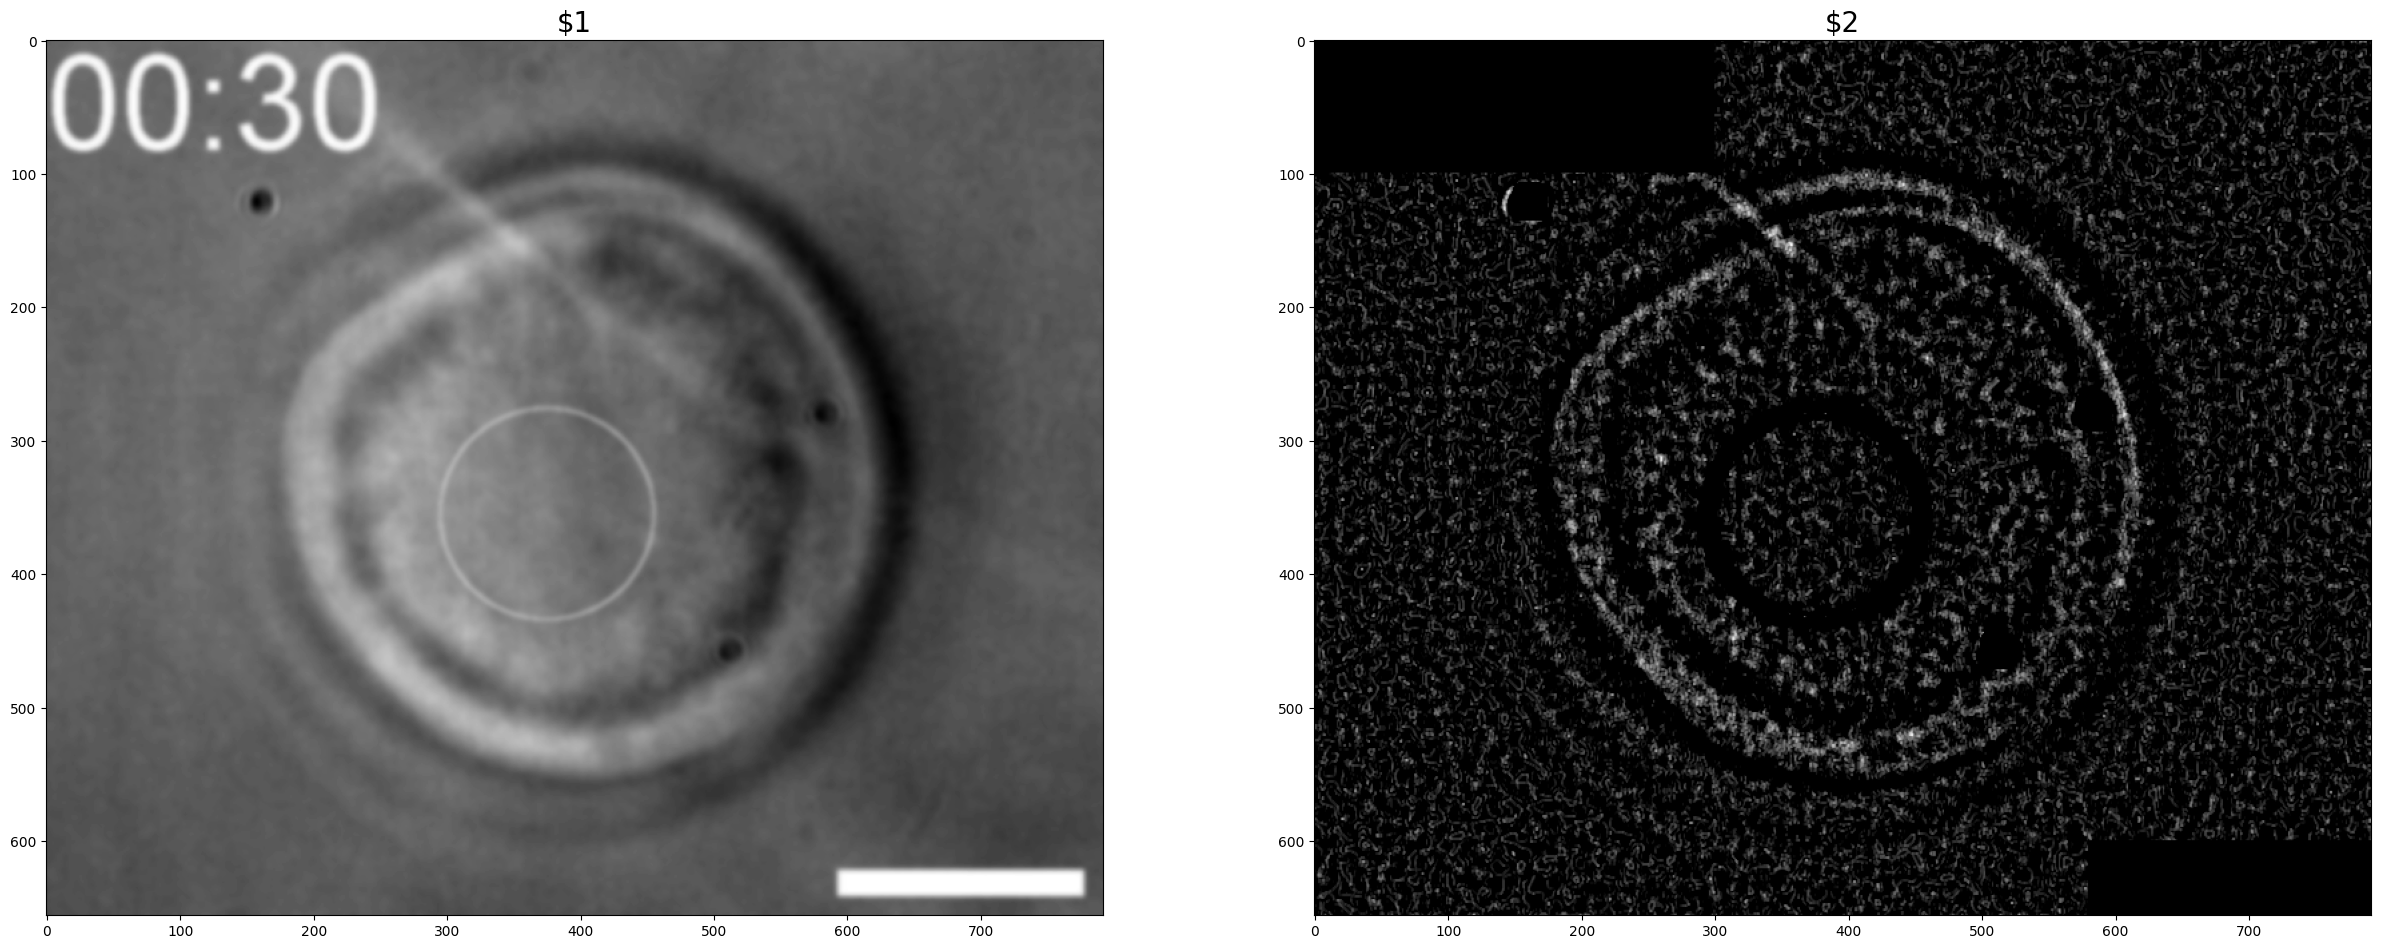

In [ ]:
index = 30

gray = p.gray_images[index].copy()

# mass center of the droplet

# edge candidates
edged = get_bright_edge(gray)
dilated_dust_mask = get_dilated_mask(p.dust_mask)
edged[dilated_dust_mask > 0] = 0
edged = delete_drawings(edged)

# b2d mask

# fitting to an ellipse

display_images([gray, edged])

In [69]:
index = 30

gray = p.gray_images[index].copy()
blurred = cv2.GaussianBlur(gray, ksize=(7, 7), sigmaX=0, sigmaY=0)
lap = cv2.Laplacian(blurred, cv2.CV_32F, ksize=5)
lap = cv2.convertScaleAbs(lap)

# lap = cv2.dilate(lap, kernel=(5, 5), iterations=1)
# lap = cv2.erode(lap, kernel=(5, 5), iterations=1)
tmp = cv2.GaussianBlur(lap, ksize=(101, 101), sigmaX=0, sigmaY=0)
thresh = np.mean(tmp[200:500]) + np.std(tmp[200:500]) * 3
print(thresh)
_, binary = cv2.threshold(lap.astype('uint16'), thresh, 2**16, cv2.THRESH_BINARY)
noise_suppressed = get_noise_suppressed(binary)

sizes, grouped = divideIntoGroups(noise_suppressed, ksize=30)
excluded = exclude_dust_groups(noise_suppressed, grouped, p.dust_mask)
median = cv2.medianBlur(excluded, ksize=7)
e = fit2ellipse(median)
cx, cy = e[0]

b2d_vector_image, cos_image = get_b2d_data(gray, cx, cy, sobel_ksize=3)

29.028488690465466


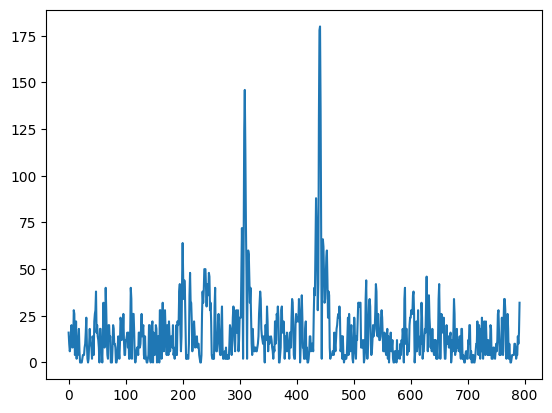

In [70]:
plt.plot(lap[400])

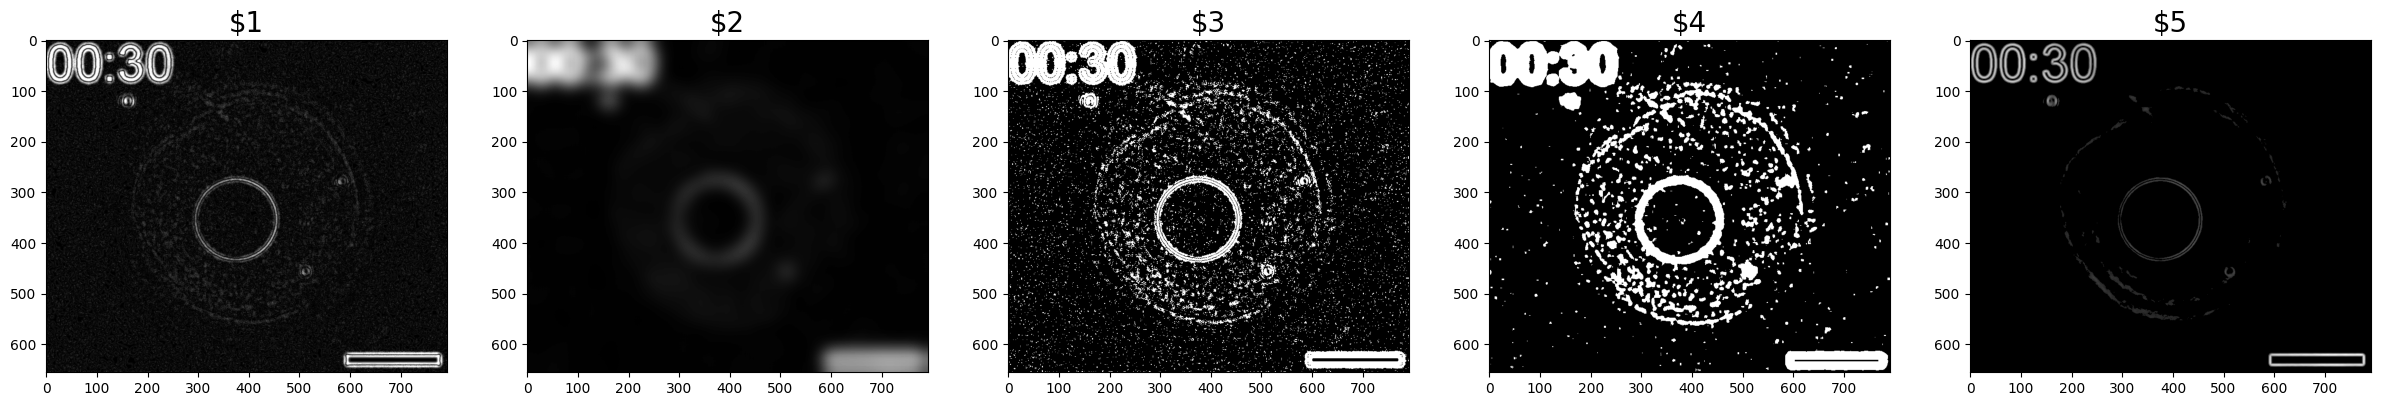

In [73]:
_b2d_vector_image = b2d_vector_image.copy()
_b2d_vector_image[b2d_vector_image < (np.mean(b2d_vector_image) + np.std(b2d_vector_image))] = 0
display_images([lap, tmp, binary, noise_suppressed, _b2d_vector_image])

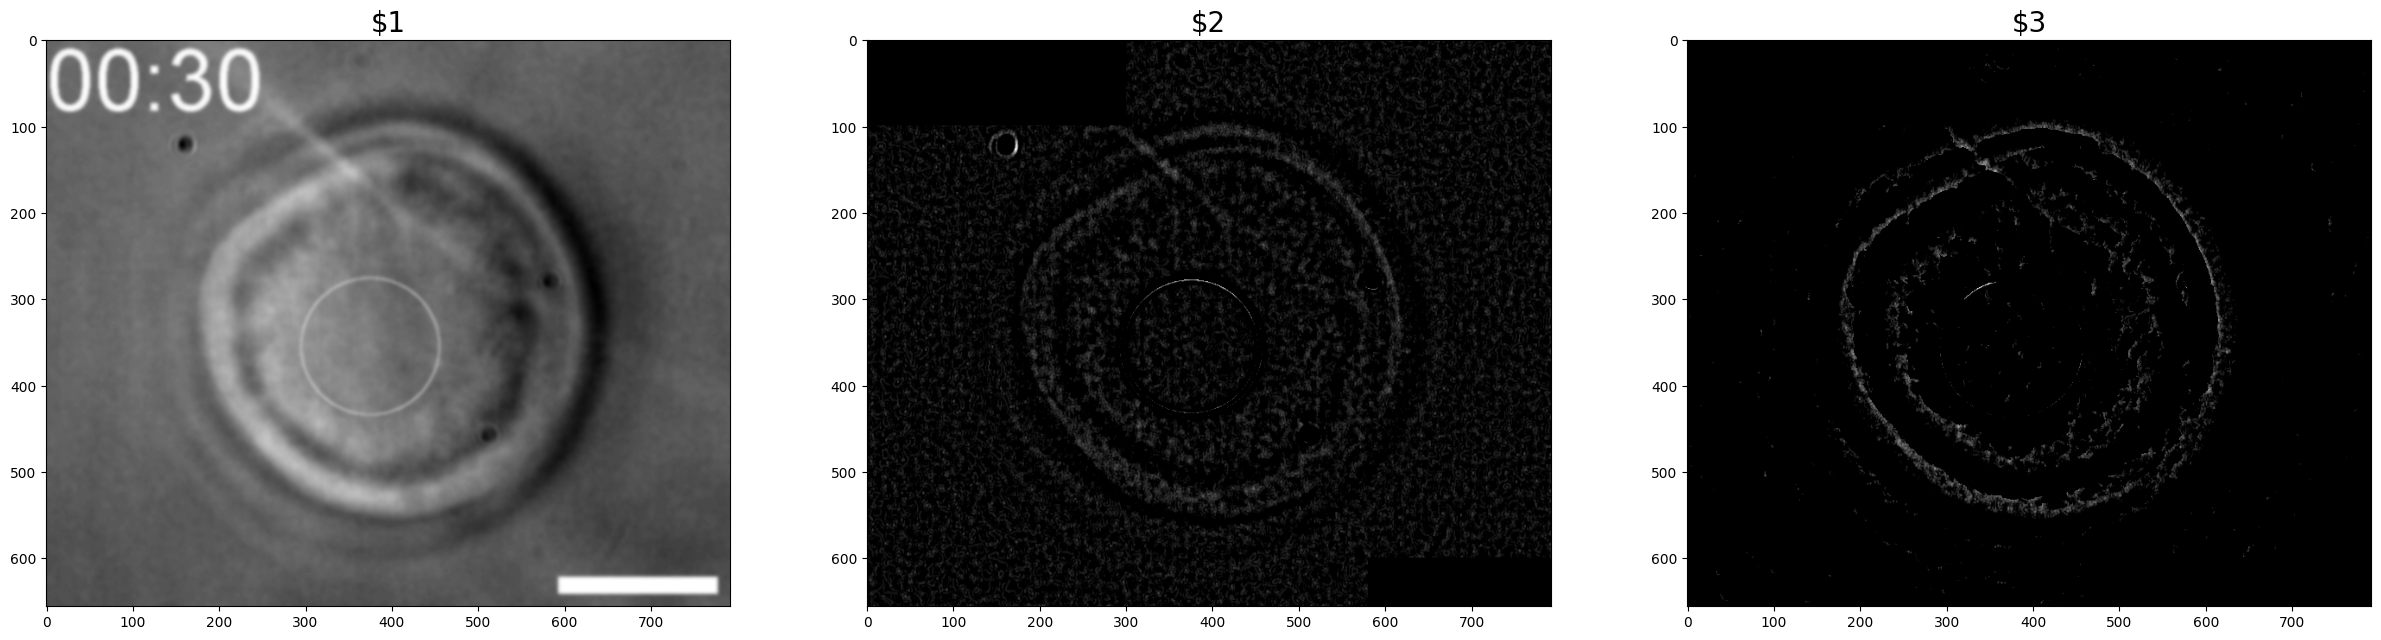

In [41]:
t_masked = t.copy()
t_masked[cos_image < 0.3] = 0
t_masked[b2d_vector_image < np.mean(b2d_vector_image)] = 0
t_masked[100:150, 130:200] = 0
display_images([gray, t, t_masked])

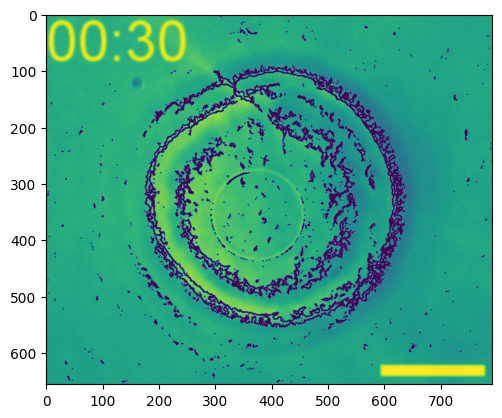

In [51]:
t_masked = (t_masked / np.max(t_masked)) * 255
t_masked = t_masked.astype('uint8')
contours, hierarchy = cv2.findContours(t_masked, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
valid_contour = np.concatenate([c for c in contours if len(c) >= 5])
img_disp = gray.copy()
cv2.drawContours(img_disp, contours, -1, (0, 0, 255), 2)
plt.imshow(img_disp)

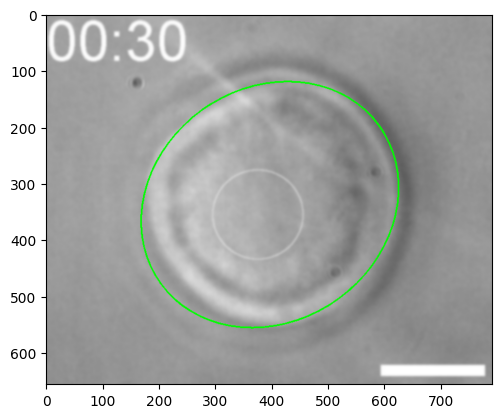

In [52]:
fitted = cv2.fitEllipse(valid_contour)
drawing = p.images[index].copy()
cv2.ellipse(drawing, fitted, (0, 255, 0), 2)
plt.imshow(drawing)

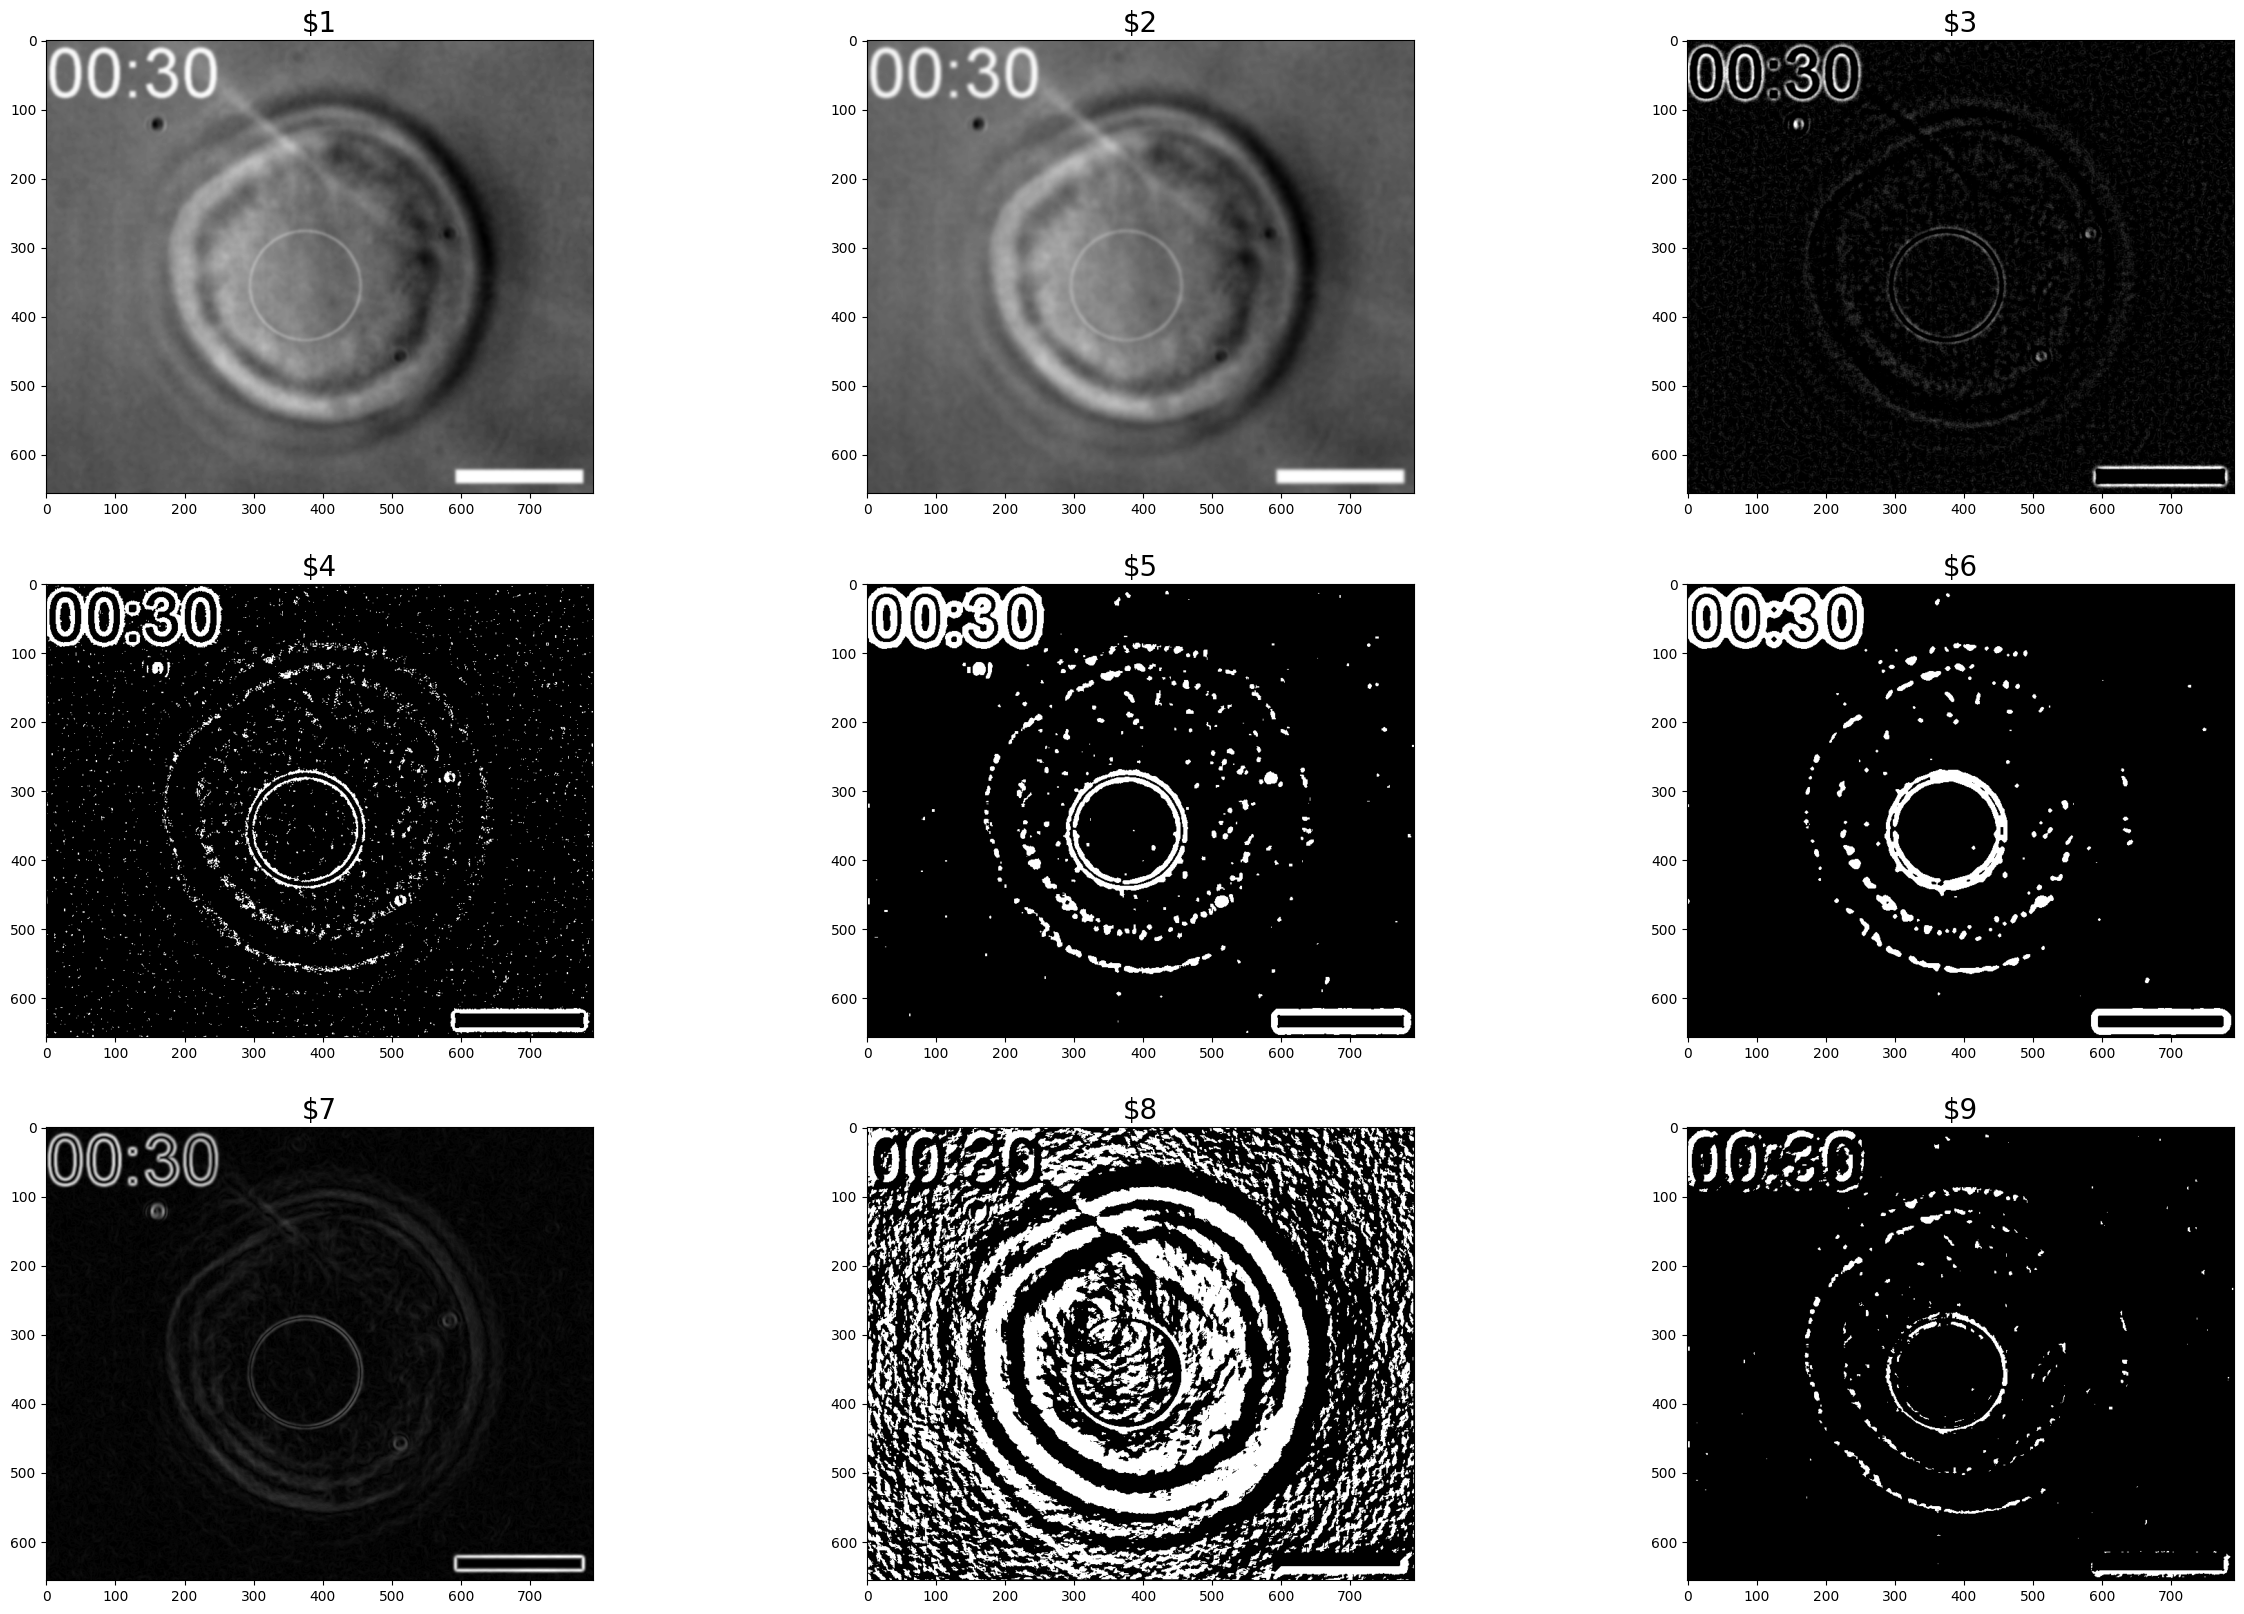

In [ ]:
cos_mask = np.zeros(gray.shape, dtype='uint8')
cos_mask[cos_image >= 0.3] = 1
sophisticated = np.copy(noise_suppressed)
sophisticated = exclude_dust_and_associated_noises(sophisticated, grouped, p.dust_mask)
sophisticated[cos_image < 0.3] = 0
# sophisticated[b2d_vector_image < np.max]
display_images([gray, blurred, lap, binary, noise_suppressed, median, b2d_vector_image, cos_mask, sophisticated], h=3)

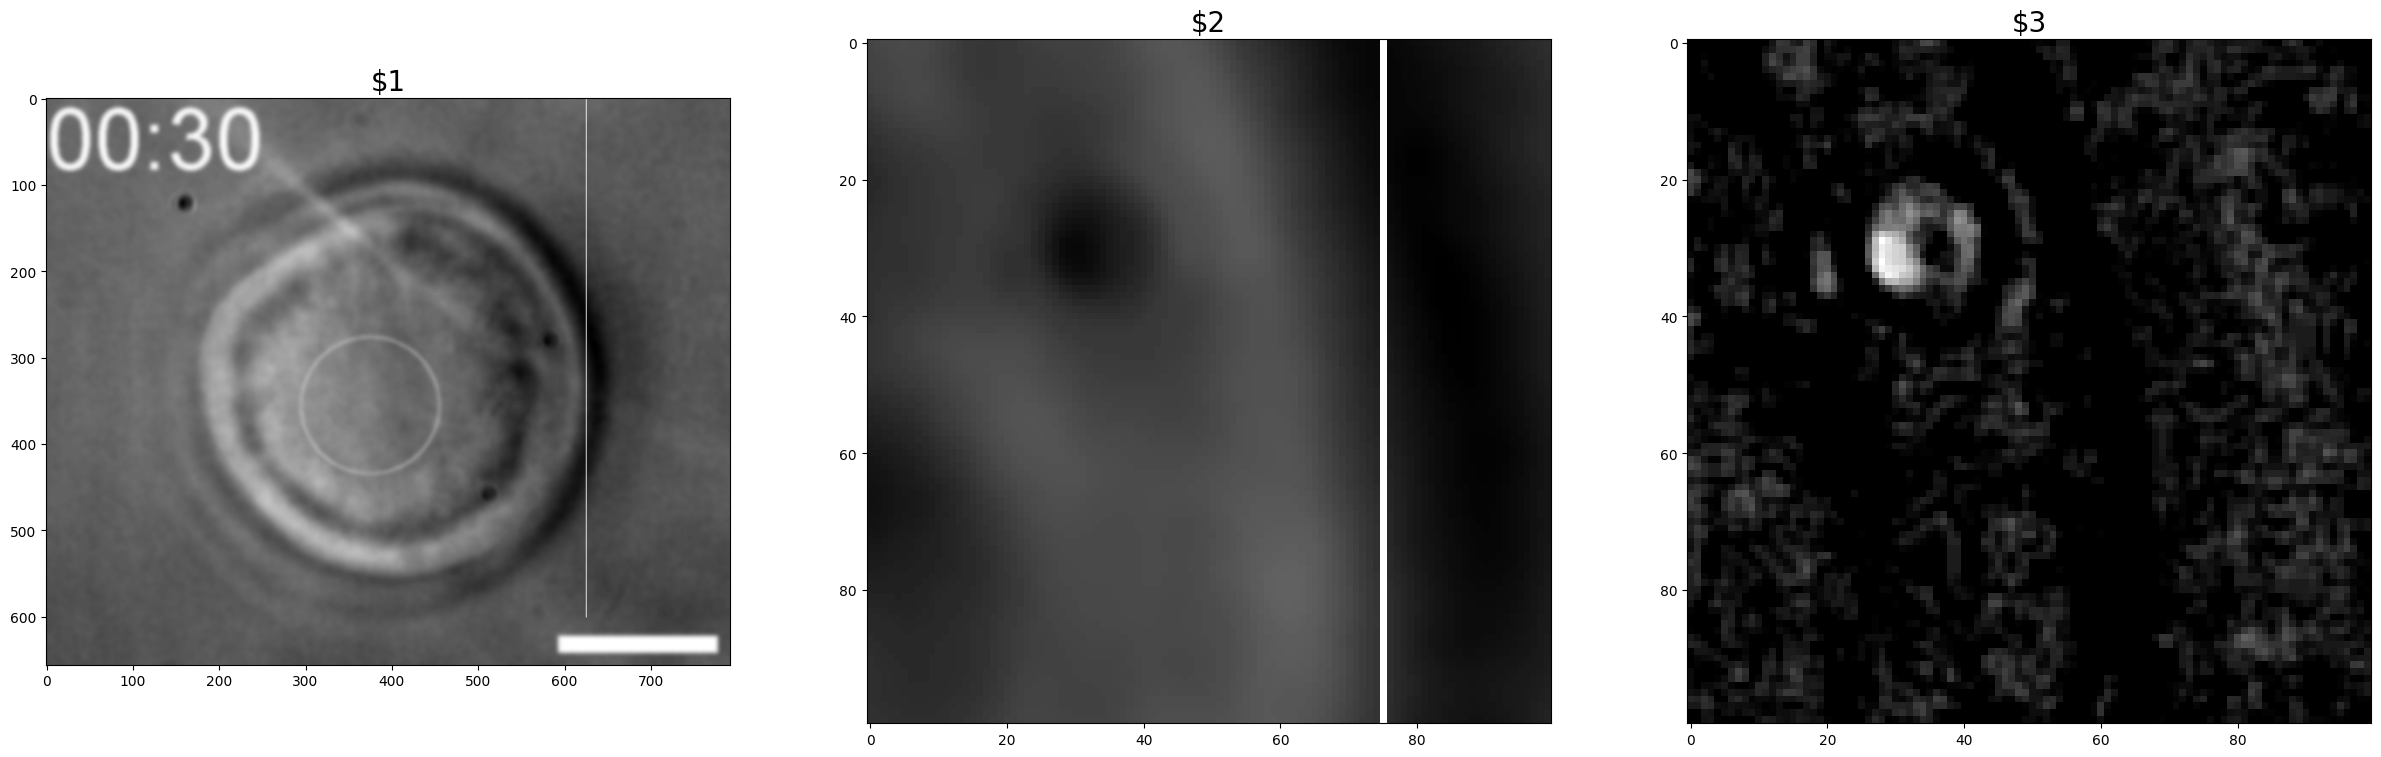

In [38]:
tmp = cv2.line(blurred.copy(), (625, 0), (625, 600), color=1000, thickness=1)

display_images([tmp, tmp[250:350, 550:650], abs(lap[250:350, 550:650])])